# Baseline RGB - ResNet18
## Beyond Visible Spectrum: AI for Agriculture 2026

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader
3. Model: ResNet18 pretrained
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 64,
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "model_name": "resnet18",
}

# Paths - LOCAL
TRAIN_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\train\RGB"
TEST_RGB_DIR = r"G:\My Drive\NCKH\git\dataset\val\RGB"
CHECKPOINT_DIR = r"G:\My Drive\NCKH\git\checkpoints"

# # Paths - KAGGLE
# TRAIN_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/train/RGB"
# TEST_RGB_DIR = "/kaggle/input/beyond-visible-spectrum/test/RGB"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

Device: cuda


In [2]:
wandb.login()


wandb: Currently logged in as: khoanguyen12062005 (khoanguyen12062005-saigon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 2. EDA - Exploratory Data Analysis

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


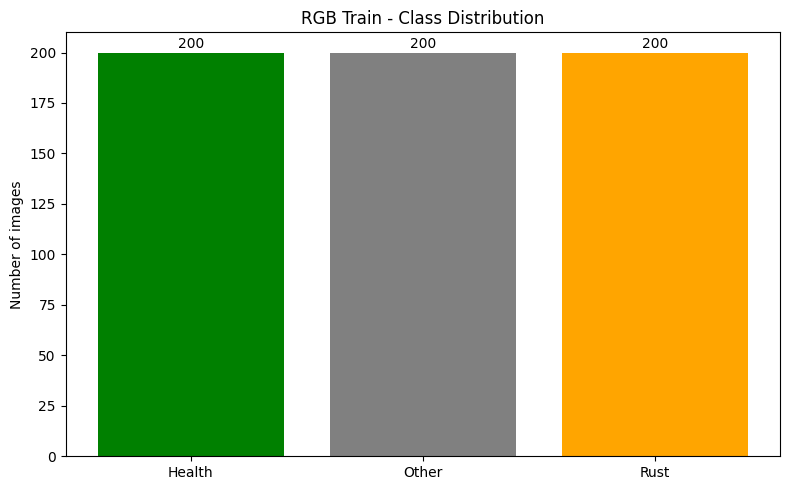

In [3]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.png' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_RGB_DIR) if f.lower().endswith(".png")]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('RGB Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

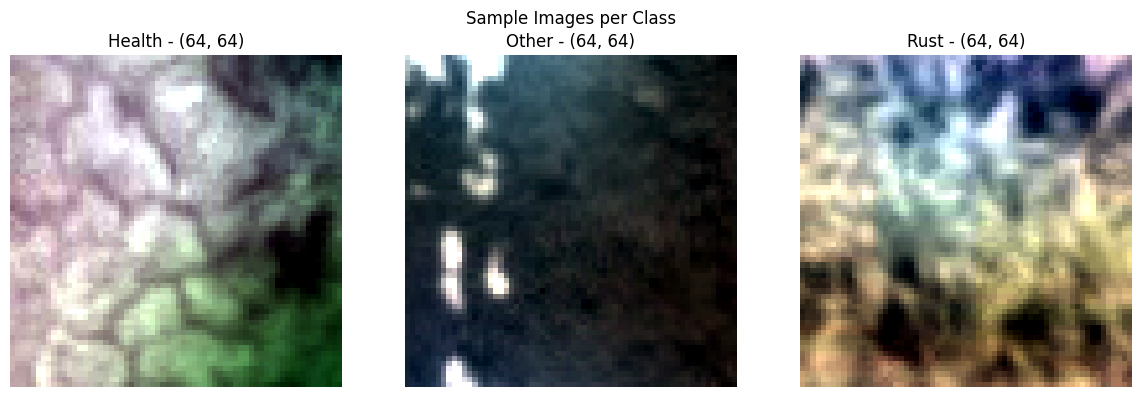

In [4]:
# Show sample images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, cls in enumerate(classes):
    sample_file = [f for f in files if label_from_filename(f) == cls][0]
    img = Image.open(os.path.join(TRAIN_RGB_DIR, sample_file))
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} - {img.size}")
    axes[i].axis('off')

plt.suptitle('Sample Images per Class')
plt.tight_layout()
plt.show()

## 3. Dataset & DataLoader

In [5]:
class RGBDataset(Dataset):
    """RGB Image Dataset - loads PNG images with labels from filename"""
    
    def __init__(self, img_dir, transform=None, file_list=None):
        self.img_dir = img_dir
        self.transform = transform
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class RGBTestDataset(Dataset):
    """RGB Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(".png")])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, fname

In [6]:
# Transforms
tfm_train = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.05,
        hue=0.0
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tfm_val = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# K-Fold Stratified Split
from sklearn.model_selection import StratifiedKFold

base_ds = RGBDataset(TRAIN_RGB_DIR, transform=None)
n_splits = 5  # K-fold value
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CONFIG["seed"])

# Create K-fold splits
kfold_splits = []
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(base_ds)), base_ds.y)):
    train_files = [base_ds.files[i] for i in train_idx]
    val_files = [base_ds.files[i] for i in val_idx]
    kfold_splits.append((train_files, val_files))

print(f"✓ Created {n_splits}-Fold splits")
for i, (train_files, val_files) in enumerate(kfold_splits):
    print(f"  Fold {i+1}: Train={len(train_files)}, Val={len(val_files)}")

# Initialize fold results tracking
fold_results = {
    "fold": [],
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}


✓ Created 5-Fold splits
  Fold 1: Train=480, Val=120
  Fold 2: Train=480, Val=120
  Fold 3: Train=480, Val=120
  Fold 4: Train=480, Val=120
  Fold 5: Train=480, Val=120


## 4. Model Definition

In [7]:
def create_model(num_classes, pretrained=True):
    """Create ResNet18 model with custom FC layer"""
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Replace final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)

print(f"Model: {CONFIG['model_name']}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: resnet18
Parameters: 11,178,051


## 5. Training

In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [9]:
from sklearn.utils.class_weight import compute_class_weight
# K-Fold Cross Validation Training
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION TRAINING")
print("="*60 + "\n")

overall_best_val_acc = 0.0
best_fold_model_path = None

for fold_idx, (train_files, val_files) in enumerate(kfold_splits, 1):
    print(f"\n{'='*60}")
    print(f"FOLD {fold_idx}/{n_splits}")
    print(f"{'='*60}")
    
    # Initialize WandB for this fold
    wandb.init(
        project="beyond-visible-spectrum",
        name=f"baseline_rgb_{CONFIG['model_name']}_fold{fold_idx}",
        config=CONFIG
    )
    
    # Create datasets for this fold
    train_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_train, file_list=train_files)
    val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=val_files)
    
    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")
    
    # Reinitialize model for each fold
    model = create_model(CONFIG["num_classes"], pretrained=True)
    model = model.to(device)
    
    # Loss & Optimizer


    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(base_ds.y),
        y=base_ds.y
    )

    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Training loop for this fold
    best_val_acc = 0.0
    fold_model_path = os.path.join(CHECKPOINT_DIR, f"best_rgb_resnet18_fold{fold_idx}.pth")
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, CONFIG["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        scheduler.step(val_acc)
        
        wandb.log({
            "epoch": epoch,
            "fold": fold_idx,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), fold_model_path)
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐")
        else:
            print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")
    
    wandb.finish()
    
    # Save fold results
    fold_results["fold"].append(fold_idx)
    fold_results["train_loss"].append(history["train_loss"][-1])
    fold_results["train_acc"].append(history["train_acc"][-1])
    fold_results["val_loss"].append(history["val_loss"][-1])
    fold_results["val_acc"].append(history["val_acc"][-1])
    
    print(f"\n✓ Fold {fold_idx} Best val_acc: {best_val_acc:.4f}")
    print(f"✓ Model saved to: {fold_model_path}")
    
    # Track best model across all folds
    if best_val_acc > overall_best_val_acc:
        overall_best_val_acc = best_val_acc
        best_fold_model_path = fold_model_path

# Print K-Fold Summary
print("\n" + "="*60)
print("K-FOLD CROSS VALIDATION SUMMARY")
print("="*60)
for i in range(len(fold_results["fold"])):
    print(f"Fold {fold_results['fold'][i]}: val_acc={fold_results['val_acc'][i]:.4f}, train_acc={fold_results['train_acc'][i]:.4f}")

avg_val_acc = np.mean(fold_results["val_acc"])
std_val_acc = np.std(fold_results["val_acc"])
print(f"\nMean Val Accuracy: {avg_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Best Overall Val Accuracy: {overall_best_val_acc:.4f}")
print(f"Best Model: {best_fold_model_path}")


K-FOLD CROSS VALIDATION TRAINING


FOLD 1/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.5104 val_acc=0.5833 ⭐
Epoch 02 | train_acc=0.7292 val_acc=0.6833 ⭐
Epoch 03 | train_acc=0.8625 val_acc=0.6833
Epoch 04 | train_acc=0.8750 val_acc=0.6250
Epoch 05 | train_acc=0.9271 val_acc=0.6750
Epoch 06 | train_acc=0.9521 val_acc=0.6583
Epoch 07 | train_acc=0.9708 val_acc=0.6583
Epoch 08 | train_acc=0.9750 val_acc=0.6583
Epoch 09 | train_acc=0.9812 val_acc=0.6583


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.9646 val_acc=0.6167


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,█████▃▃▃▃▁
train_acc,▁▄▆▆▇█████
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▁██▄▇▆▆▆▆▃
val_loss,█▂▂▁▂▃▁▁▁▂
epoch,10
fold,1
lr,3e-05
train_acc,0.96458



✓ Fold 1 Best val_acc: 0.6833
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold1.pth

FOLD 2/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4521 val_acc=0.5500 ⭐
Epoch 02 | train_acc=0.6958 val_acc=0.5917 ⭐
Epoch 03 | train_acc=0.8042 val_acc=0.5917
Epoch 04 | train_acc=0.8833 val_acc=0.5917
Epoch 05 | train_acc=0.9396 val_acc=0.5917
Epoch 06 | train_acc=0.9563 val_acc=0.6167 ⭐
Epoch 07 | train_acc=0.9646 val_acc=0.5667
Epoch 08 | train_acc=0.9688 val_acc=0.5917
Epoch 09 | train_acc=0.9708 val_acc=0.6000


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.9771 val_acc=0.5917


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,█████████▁
train_acc,▁▄▆▇██████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▅▅▅▅█▃▅▆▅
val_loss,▂▁▁▁▂▂▄▆▇█
epoch,10
fold,2
lr,5e-05
train_acc,0.97708



✓ Fold 2 Best val_acc: 0.6167
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold2.pth

FOLD 3/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4417 val_acc=0.5250 ⭐
Epoch 02 | train_acc=0.7354 val_acc=0.5667 ⭐
Epoch 03 | train_acc=0.8542 val_acc=0.5667
Epoch 04 | train_acc=0.8979 val_acc=0.5833 ⭐
Epoch 05 | train_acc=0.9396 val_acc=0.5750
Epoch 06 | train_acc=0.9625 val_acc=0.5917 ⭐
Epoch 07 | train_acc=0.9625 val_acc=0.5750
Epoch 08 | train_acc=0.9729 val_acc=0.5750
Epoch 09 | train_acc=0.9812 val_acc=0.5750


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.9750 val_acc=0.5833


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,█████████▁
train_acc,▁▅▆▇▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▅▅▇▆█▆▆▆▇
val_loss,▃▂▁▁▃▃▄▆██
epoch,10
fold,3
lr,5e-05
train_acc,0.975



✓ Fold 3 Best val_acc: 0.5917
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold3.pth

FOLD 4/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.5021 val_acc=0.5500 ⭐
Epoch 02 | train_acc=0.7271 val_acc=0.5833 ⭐
Epoch 03 | train_acc=0.8521 val_acc=0.5750
Epoch 04 | train_acc=0.8917 val_acc=0.6000 ⭐
Epoch 05 | train_acc=0.9333 val_acc=0.5750
Epoch 06 | train_acc=0.9396 val_acc=0.5333
Epoch 07 | train_acc=0.9479 val_acc=0.5750
Epoch 08 | train_acc=0.9750 val_acc=0.6000
Epoch 09 | train_acc=0.9708 val_acc=0.6000


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.9771 val_acc=0.5917


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,███████▁▁▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▃▆▅█▅▁▅██▇
val_loss,▂▁▁▂▄▇▆█▇█
epoch,10
fold,4
lr,5e-05
train_acc,0.97708



✓ Fold 4 Best val_acc: 0.6000
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold4.pth

FOLD 5/5


Train: 480, Val: 120
Epoch 01 | train_acc=0.4250 val_acc=0.5250 ⭐
Epoch 02 | train_acc=0.7167 val_acc=0.5583 ⭐
Epoch 03 | train_acc=0.8417 val_acc=0.5333
Epoch 04 | train_acc=0.8875 val_acc=0.5667 ⭐
Epoch 05 | train_acc=0.9146 val_acc=0.5750 ⭐
Epoch 06 | train_acc=0.9542 val_acc=0.5667
Epoch 07 | train_acc=0.9521 val_acc=0.5583
Epoch 08 | train_acc=0.9708 val_acc=0.5667
Epoch 09 | train_acc=0.9729 val_acc=0.5750


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 10 | train_acc=0.9771 val_acc=0.5583


epoch,▁▂▃▃▄▅▆▆▇█
fold,▁▁▁▁▁▁▁▁▁▁
lr,████████▁▁
train_acc,▁▅▆▇▇█████
train_loss,█▄▃▃▂▂▁▁▁▁
val_acc,▁▆▂▇█▇▆▇█▆
val_loss,▂▁▁▃▅▅▆███
epoch,10
fold,5
lr,5e-05
train_acc,0.97708



✓ Fold 5 Best val_acc: 0.5750
✓ Model saved to: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold5.pth

K-FOLD CROSS VALIDATION SUMMARY
Fold 1: val_acc=0.6167, train_acc=0.9646
Fold 2: val_acc=0.5917, train_acc=0.9771
Fold 3: val_acc=0.5833, train_acc=0.9750
Fold 4: val_acc=0.5917, train_acc=0.9771
Fold 5: val_acc=0.5583, train_acc=0.9771

Mean Val Accuracy: 0.5883 ± 0.0187
Best Overall Val Accuracy: 0.6833
Best Model: G:\My Drive\NCKH\git\checkpoints\best_rgb_resnet18_fold1.pth


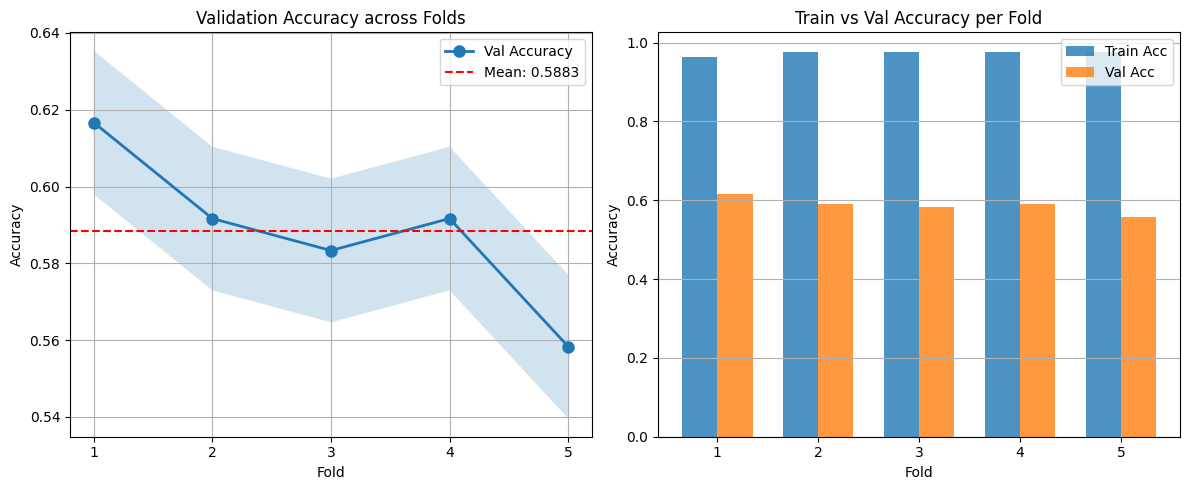

In [10]:
# Plot K-Fold Results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

folds = fold_results["fold"]

# Val Accuracy across folds
axes[0].plot(folds, fold_results["val_acc"], marker='o', label="Val Accuracy", linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(fold_results["val_acc"]), color='r', linestyle='--', label=f'Mean: {np.mean(fold_results["val_acc"]):.4f}')
axes[0].fill_between(folds, 
                      np.array(fold_results["val_acc"]) - np.std(fold_results["val_acc"]),
                      np.array(fold_results["val_acc"]) + np.std(fold_results["val_acc"]),
                      alpha=0.2)
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Validation Accuracy across Folds")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(folds)

# Train vs Val accuracy for each fold
x = np.arange(len(folds))
width = 0.35
axes[1].bar(x - width/2, fold_results["train_acc"], width, label="Train Acc", alpha=0.8)
axes[1].bar(x + width/2, fold_results["val_acc"], width, label="Val Acc", alpha=0.8)
axes[1].set_xlabel("Fold")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Train vs Val Accuracy per Fold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(folds)
axes[1].legend()
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

## 6. Evaluation

In [11]:
# Load best model from best fold for evaluation
# Find which fold had the best model
best_fold_idx = fold_results["val_acc"].index(max(fold_results["val_acc"])) + 1
best_train_files, best_val_files = kfold_splits[best_fold_idx - 1]

# Recreate best fold's validation dataset
val_ds = RGBDataset(TRAIN_RGB_DIR, transform=tfm_val, file_list=best_val_files)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)

print(f"\n{'='*60}")
print(f"EVALUATION on Best Fold ({best_fold_idx})")
print(f"Val samples: {len(val_ds)}")
print(f"{'='*60}\n")

# Load best model
model = create_model(CONFIG["num_classes"], pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load(best_fold_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


EVALUATION on Best Fold (1)
Val samples: 120

Classification Report:
              precision    recall  f1-score   support

      Health       0.64      0.35      0.45        40
       Other       0.81      0.85      0.83        40
        Rust       0.59      0.82      0.69        40

    accuracy                           0.68       120
   macro avg       0.68      0.67      0.66       120
weighted avg       0.68      0.68      0.66       120



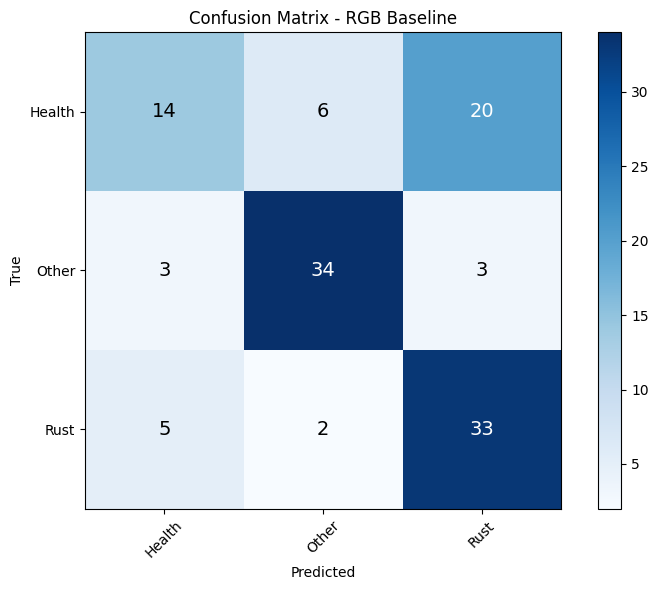

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - RGB Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

=== Collecting Misclassified Images ===

Total misclassified: 40

Breakdown by type:
  Health → Other: 6 images
  Health → Rust: 20 images
  Other → Health: 3 images
  Other → Rust: 4 images
  Rust → Health: 5 images
  Rust → Other: 2 images

=== Visualizing Misclassified Images ===



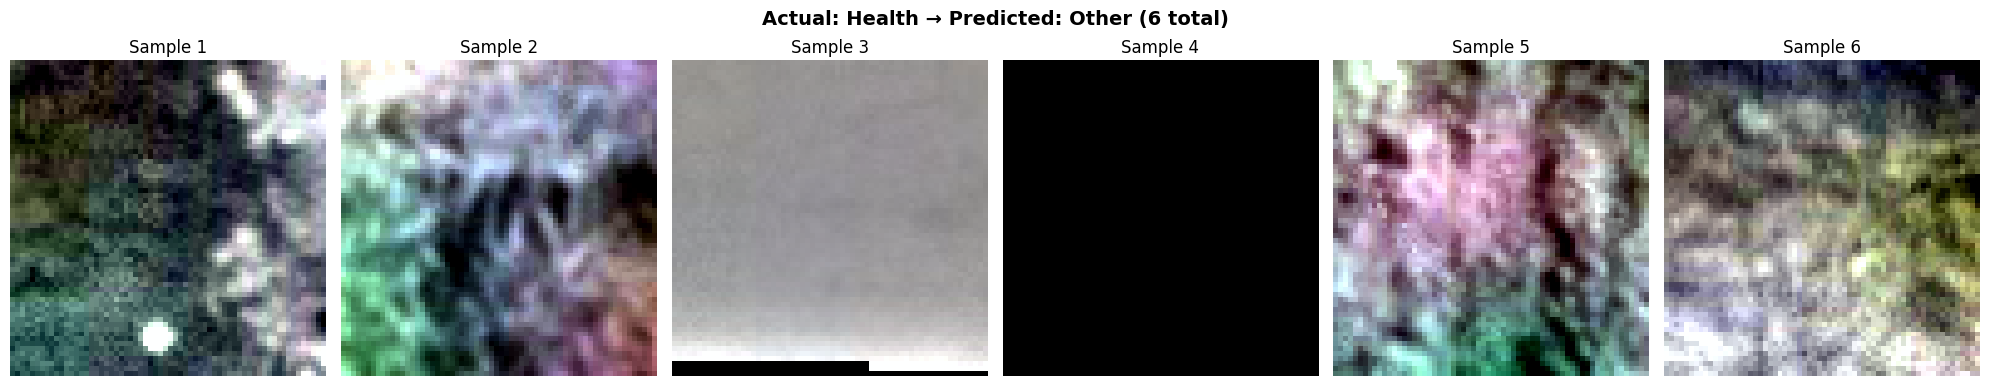

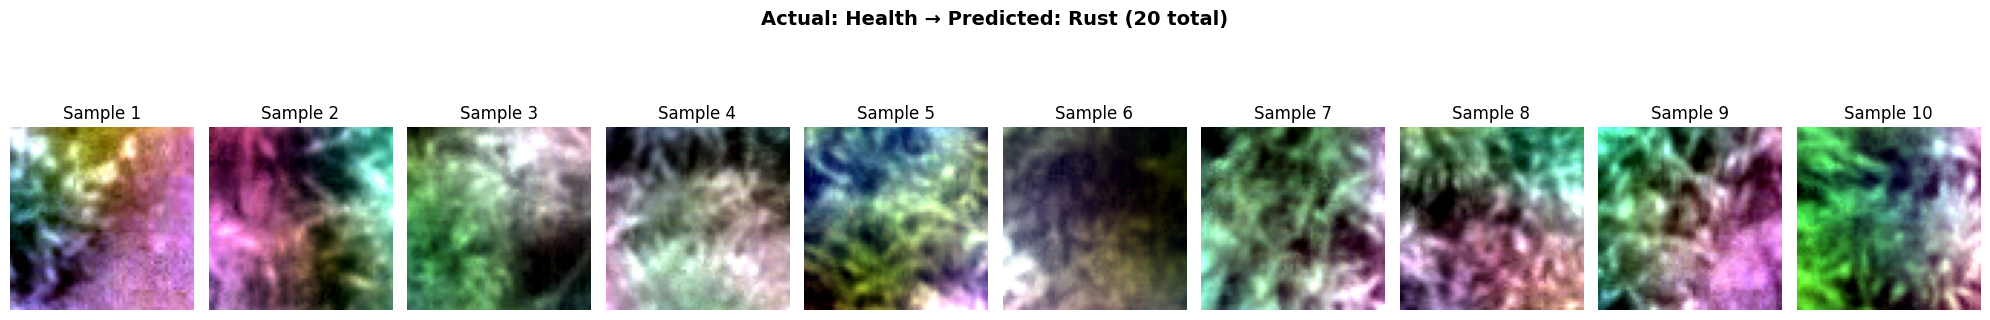

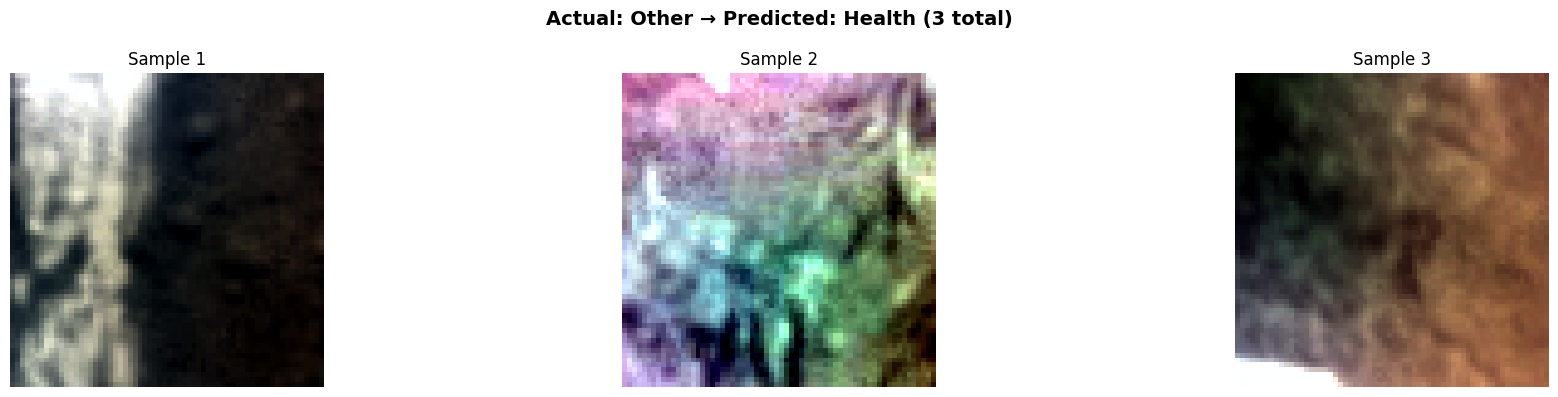

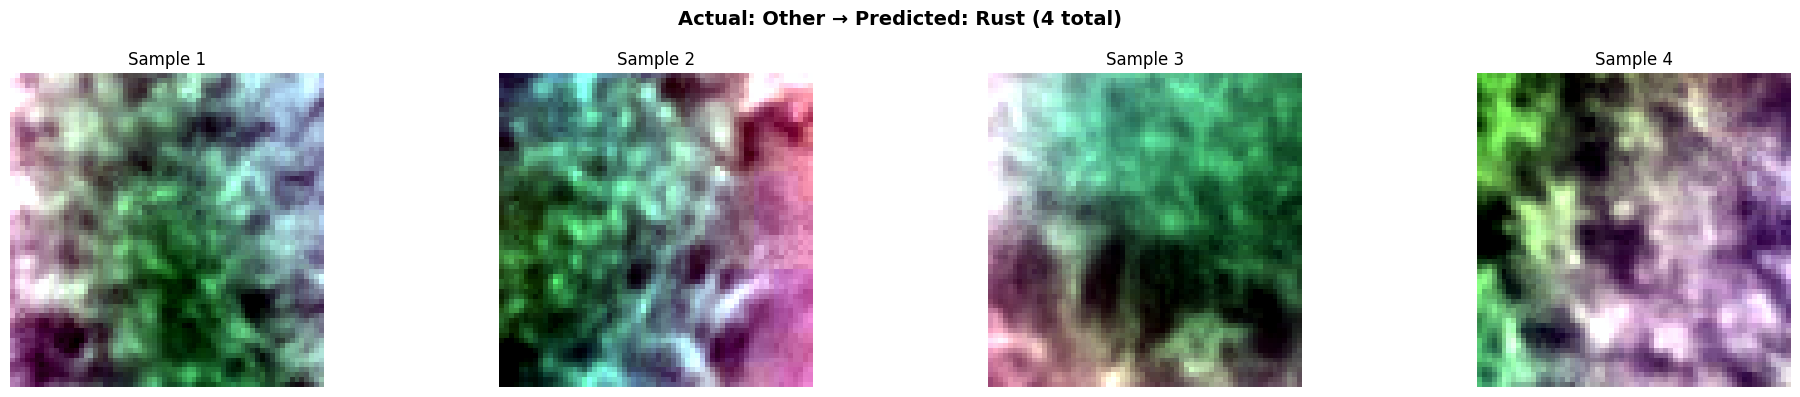

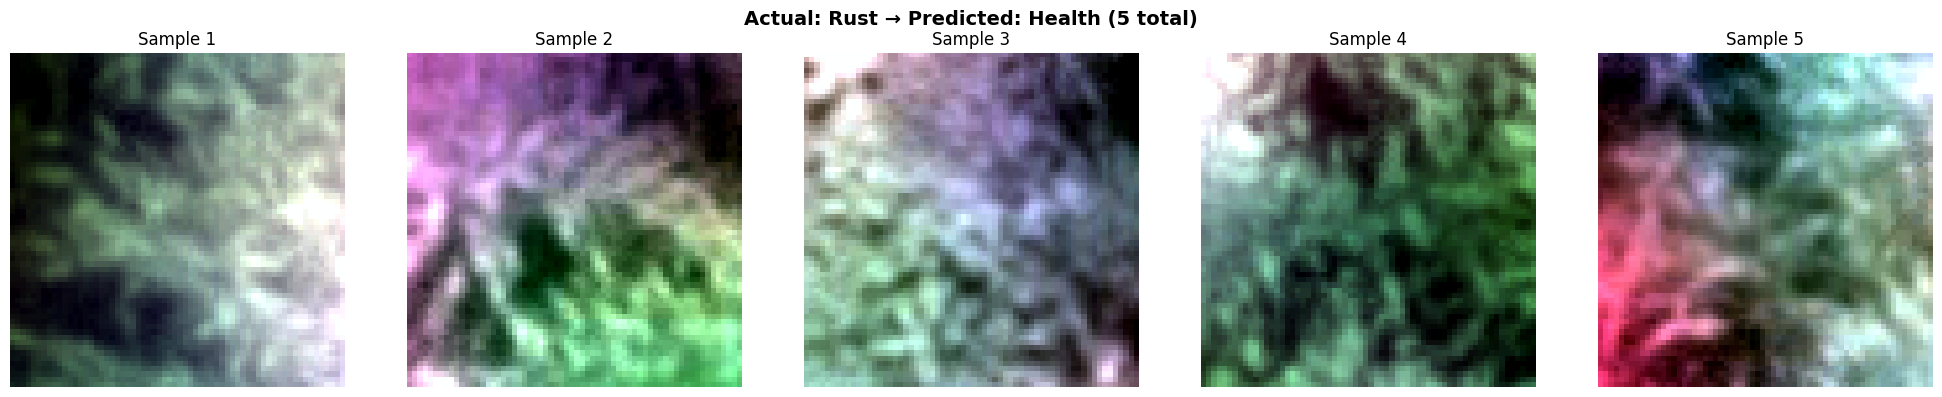

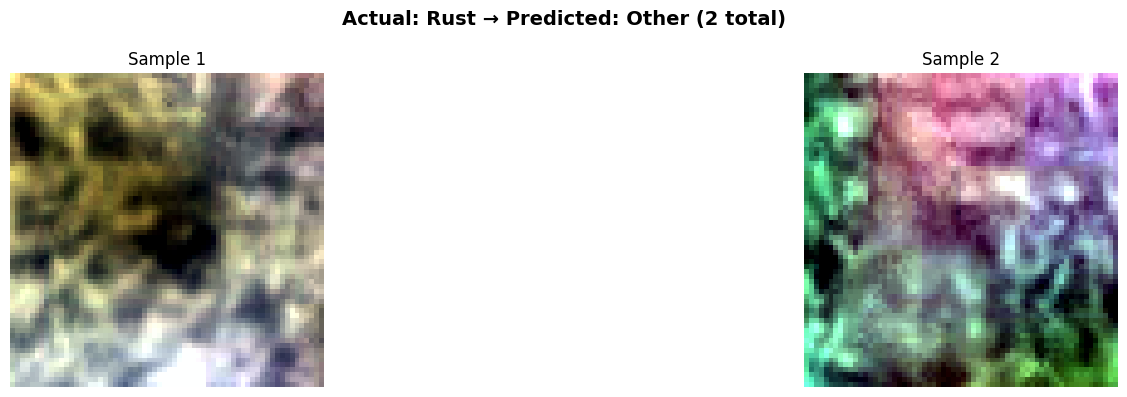

In [13]:
# Visualize Misclassified Images with proper denormalization
from collections import defaultdict

# Get predictions with image indices
misclassified = defaultdict(list)

print("=== Collecting Misclassified Images ===\n")

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            misclassified[(true_label, pred_label)].append(idx)

print(f"Total misclassified: {sum(len(v) for v in misclassified.values())}")
print("\nBreakdown by type:")
for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    print(f"  {true_lbl} → {pred_lbl}: {len(indices)} images")

# Denormalization constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def denormalize_image(img_tensor):
    """Denormalize ImageNet-normalized image tensor"""
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = img_np * IMAGENET_STD + IMAGENET_MEAN
    img_np = np.clip(img_np, 0, 1)
    return img_np

# Visualize
print("\n=== Visualizing Misclassified Images ===\n")

for (true_lbl, pred_lbl), indices in sorted(misclassified.items()):
    num_show = min(10, len(indices))
    fig, axes = plt.subplots(1, num_show, figsize=(20, 4))
    
    if num_show == 1:
        axes = [axes]
    
    fig.suptitle(f"Actual: {true_lbl} → Predicted: {pred_lbl} ({len(indices)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


ANALYSIS: Health (Thực tế) → Rust (Dự đoán)

Tổng cộng: 20 ảnh Health dự đoán sai thành Rust



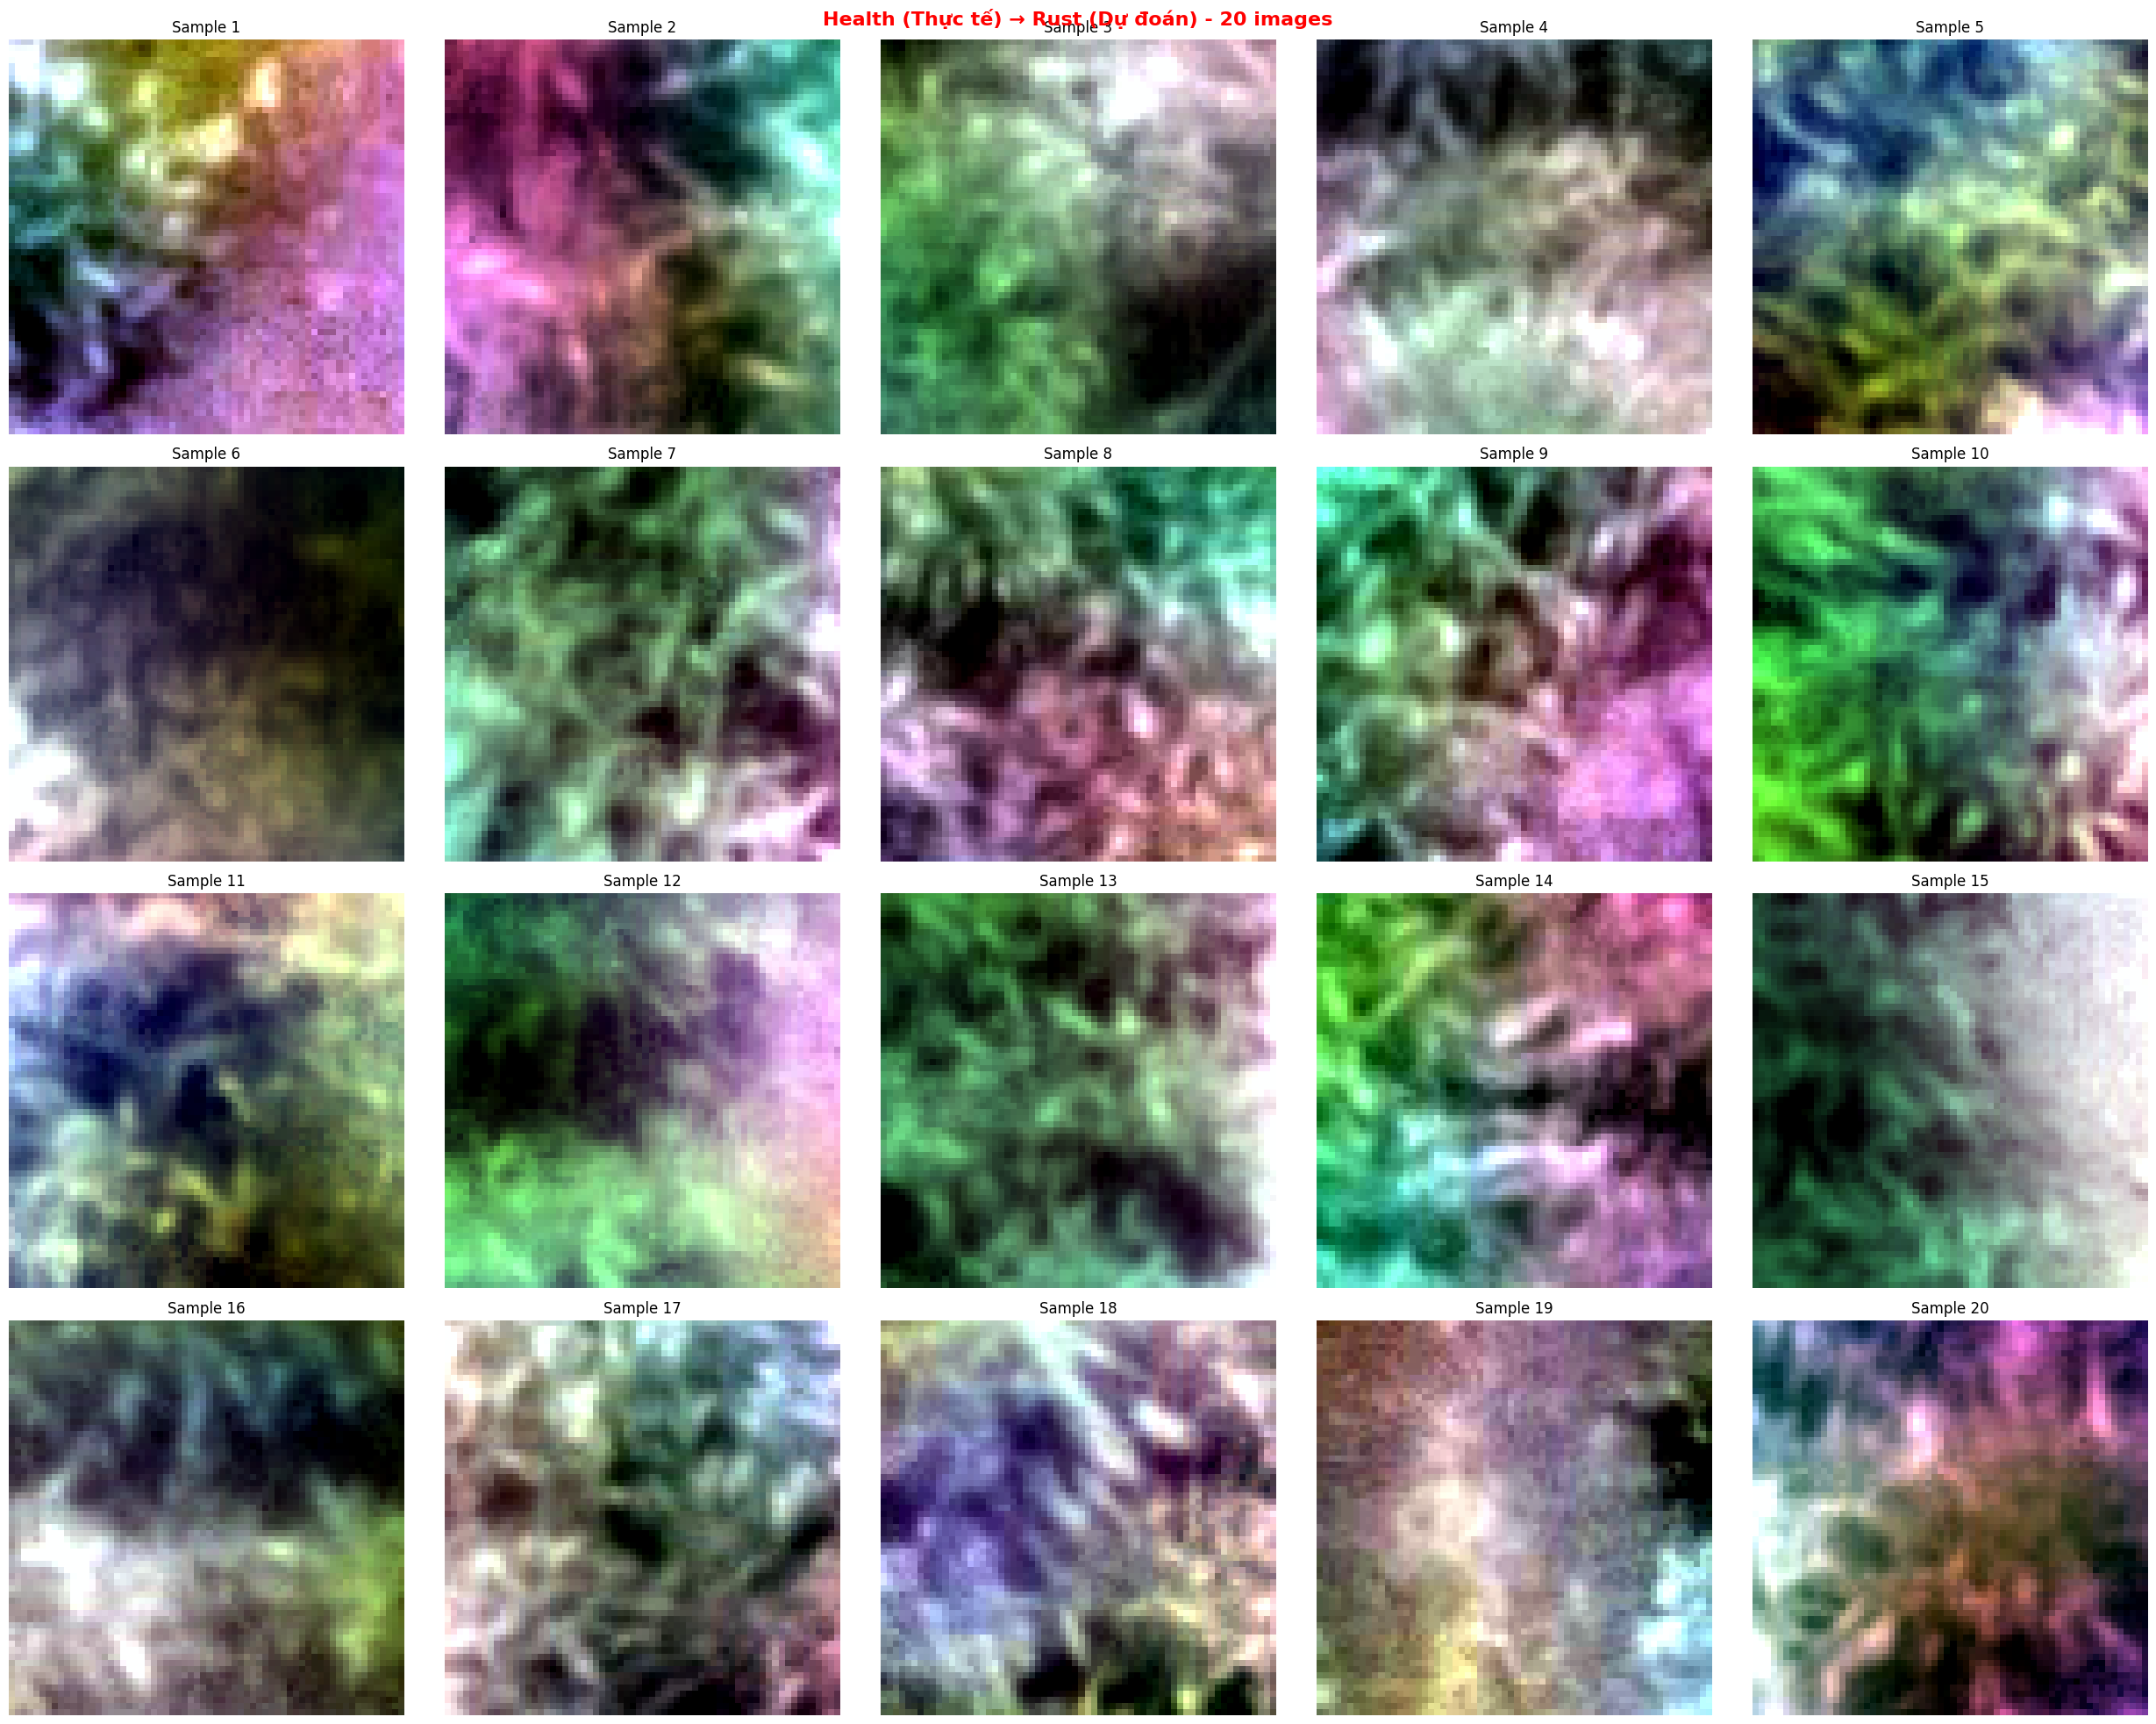

✓ Hiển thị 20 ảnh mẫu từ 20 tổng cộng


In [14]:
import math
# Visualize specific misclassification: Health → Rust
print("=" * 60)
print("ANALYSIS: Health (Thực tế) → Rust (Dự đoán)")
print("=" * 60)

true_lbl, pred_lbl = "Health", "Rust"

if (true_lbl, pred_lbl) in misclassified:
    indices = misclassified[(true_lbl, pred_lbl)]
    num_show = min(29, len(indices))
    
    print(f"\nTổng cộng: {len(indices)} ảnh Health dự đoán sai thành Rust\n")
    
    cols = 5
    rows = math.ceil(num_show / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten()
    
    fig.suptitle(f"Health (Thực tế) → Rust (Dự đoán) - {len(indices)} images", 
                 fontsize=16, fontweight='bold', color='red')
    
    for i, idx in enumerate(indices[:num_show]):
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}", fontsize=12)
        axes[i].axis('off')
    
    # Hide extra subplots
    for i in range(num_show, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Hiển thị {num_show} ảnh mẫu từ {len(indices)} tổng cộng")
else:
    print(f"❌ Không tìm thấy misclassification: {true_lbl} → {pred_lbl}")


## 7. Inference & Submission

In [15]:
# Check if test directory exists
if os.path.exists(TEST_RGB_DIR):
    # Create test dataset
    test_ds = RGBTestDataset(TEST_RGB_DIR, transform=tfm_val)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)
    
    print(f"Test samples: {len(test_ds)}")
else:
    print(f"⚠️ Test directory not found: {TEST_RGB_DIR}")
    print("Skipping test inference...")

Test samples: 300


In [16]:
# Run inference on test set
if os.path.exists(TEST_RGB_DIR):
    model.eval()
    predictions = []
    filenames = []
    
    idx_to_class = val_ds.idx_to_class
    
    with torch.no_grad():
        for images, fnames in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # Convert to class names
            pred_labels = [idx_to_class[p] for p in preds]
            
            predictions.extend(pred_labels)
            filenames.extend(fnames)
    
    print(f"✓ Predicted {len(predictions)} test samples")
    print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

✓ Predicted 300 test samples
Sample predictions: [('val_000a83c1.png', 'Health'), ('val_00a704b1.png', 'Health'), ('val_01dde030.png', 'Health'), ('val_024df365.png', 'Rust'), ('val_02afcb0e.png', 'Health')]


In [17]:
# import pandas as pd

# df = pd.read_csv(r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_task1_rgb.csv")

# label_map = {
#     "rust": "Rust",
#     "other": "Other",
#     "healthy": "Health"
# }

# df["label"] = df["label"].map(label_map)

# df.to_csv("submission_task1_rgb_FIXED.csv", index=False)
# print(df.head())


In [18]:
import os
import pandas as pd

if os.path.exists(TEST_RGB_DIR):
    submission_df = pd.DataFrame({
        "ID": filenames,      # TÊN CỘT ĐÚNG
        "label": predictions        # Rust / Other / Health
    })

    # sort cho đẹp (không bắt buộc nhưng nên làm)
    submission_df = submission_df.sort_values("ID").reset_index(drop=True)

    submission_path = os.path.join(CHECKPOINT_DIR, "submission_rgb.csv")
    submission_df.to_csv(submission_path, index=False)

    print(f"✓ Saved submission to: {submission_path}")
    print(f"✓ Total predictions: {len(submission_df)}")

    print("\nFirst 10 rows:")
    print(submission_df.head(10))

    print("\nLabel distribution:")
    print(submission_df["label"].value_counts())
else:
    print("⚠️ No test data - submission not created")


✓ Saved submission to: G:\My Drive\NCKH\git\checkpoints\submission_rgb.csv
✓ Total predictions: 300

First 10 rows:
                 ID   label
0  val_000a83c1.png  Health
1  val_00a704b1.png  Health
2  val_01dde030.png  Health
3  val_024df365.png    Rust
4  val_02afcb0e.png  Health
5  val_03864ba6.png  Health
6  val_0537e324.png    Rust
7  val_059983e0.png   Other
8  val_05cee914.png   Other
9  val_07af871a.png    Rust

Label distribution:
label
Rust      122
Other      95
Health     83
Name: count, dtype: int64


## 8. Overfitting Analysis (Optional)

In [19]:
# import pandas as pd

# # Giả sử submission_df là dataframe cũ của bạn
# submission_df = pd.DataFrame({
#     'Id': filenames,         # Đổi từ 'filename' sang 'Id'
#     'Category': formatted_labels  # Đổi từ 'label' sang 'Category' (kiểm tra lại tên cột này của BTC)
# })

# # Lưu file mới
# submission_df.to_csv('submission_task1_final.csv', index=False)

In [20]:
# Check for potential overfitting signs
print("=== Overfitting Analysis ===")
print(f"\nDataset size: {len(base_ds)} images")
print(f"Train/Val split: {len(train_ds)}/{len(val_ds)}")

# Gap between train and val accuracy
final_train_acc = history["train_acc"][-1]
final_val_acc = history["val_acc"][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Final Val Accuracy: {final_val_acc:.4f}")
print(f"Gap (Train - Val): {gap:.4f}")

if gap > 0.1:
    print("⚠️ Large gap detected - possible overfitting!")
    print("   Suggestions: More augmentation, dropout, early stopping")
elif final_val_acc > 0.95:
    print("⚠️ Very high val_acc - check for data leakage!")
else:
    print("✓ Gap looks reasonable")

=== Overfitting Analysis ===

Dataset size: 600 images
Train/Val split: 480/120

Final Train Accuracy: 0.9771
Final Val Accuracy: 0.5583
Gap (Train - Val): 0.4187
⚠️ Large gap detected - possible overfitting!
   Suggestions: More augmentation, dropout, early stopping


In [22]:
# List all misclassified images by category
print("=" * 80)
print("MISCLASSIFIED IMAGES - ORGANIZED BY TRUE LABEL → PREDICTED LABEL")
print("=" * 80)

# Dictionary to store misclassified images
misclassified_by_type = {}

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        # Only process misclassified
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            filename = val_ds.files[idx]
            
            # Create key for this misclassification type
            key = f"{true_label} → {pred_label}"
            
            if key not in misclassified_by_type:
                misclassified_by_type[key] = []
            
            misclassified_by_type[key].append(filename)

# Sort and display
total_misclassified = sum(len(v) for v in misclassified_by_type.values())
print(f"\nTOTAL MISCLASSIFIED: {total_misclassified} images\n")

# Display organized by category
for key in sorted(misclassified_by_type.keys()):
    filenames = misclassified_by_type[key]
    print(f"\n{key} ({len(filenames)} images):")
    print("-" * 80)
    for filename in sorted(filenames):
        print(f"  • {filename}")

# Summary
print(f"\n\n{'=' * 80}")
print("SUMMARY")
print("=" * 80)
for key in sorted(misclassified_by_type.keys()):
    print(f"{key}: {len(misclassified_by_type[key])} images")

MISCLASSIFIED IMAGES - ORGANIZED BY TRUE LABEL → PREDICTED LABEL

TOTAL MISCLASSIFIED: 40 images


Health → Other (6 images):
--------------------------------------------------------------------------------
  • Health_hyper_126.png
  • Health_hyper_146.png
  • Health_hyper_168.png
  • Health_hyper_26.png
  • Health_hyper_35.png
  • Health_hyper_57.png

Health → Rust (20 images):
--------------------------------------------------------------------------------
  • Health_hyper_10.png
  • Health_hyper_100.png
  • Health_hyper_118.png
  • Health_hyper_137.png
  • Health_hyper_138.png
  • Health_hyper_140.png
  • Health_hyper_156.png
  • Health_hyper_171.png
  • Health_hyper_180.png
  • Health_hyper_183.png
  • Health_hyper_184.png
  • Health_hyper_187.png
  • Health_hyper_195.png
  • Health_hyper_2.png
  • Health_hyper_31.png
  • Health_hyper_5.png
  • Health_hyper_50.png
  • Health_hyper_61.png
  • Health_hyper_79.png
  • Health_hyper_96.png

Other → Health (3 images):
-------------------

=== Re-predicting Misclassified Images ===

Total misclassified images: 40

Top 10 Most Confident Misclassified Predictions:
----------------------------------------------------------------------------------------------------
1. Image: Health_hyper_2.png
   True Label: Health
   Predicted: Rust (Confidence: 0.9074)
   Top-3 Predictions:
      1. Rust: 0.9074
      2. Health: 0.0621
      3. Other: 0.0304

2. Image: Health_hyper_138.png
   True Label: Health
   Predicted: Rust (Confidence: 0.8612)
   Top-3 Predictions:
      1. Rust: 0.8612
      2. Health: 0.0967
      3. Other: 0.0420

3. Image: Health_hyper_195.png
   True Label: Health
   Predicted: Rust (Confidence: 0.8505)
   Top-3 Predictions:
      1. Rust: 0.8505
      2. Health: 0.1044
      3. Other: 0.0451

4. Image: Health_hyper_171.png
   True Label: Health
   Predicted: Rust (Confidence: 0.8471)
   Top-3 Predictions:
      1. Rust: 0.8471
      2. Health: 0.0889
      3. Other: 0.0639

5. Image: Health_hyper_35.png
   Tru

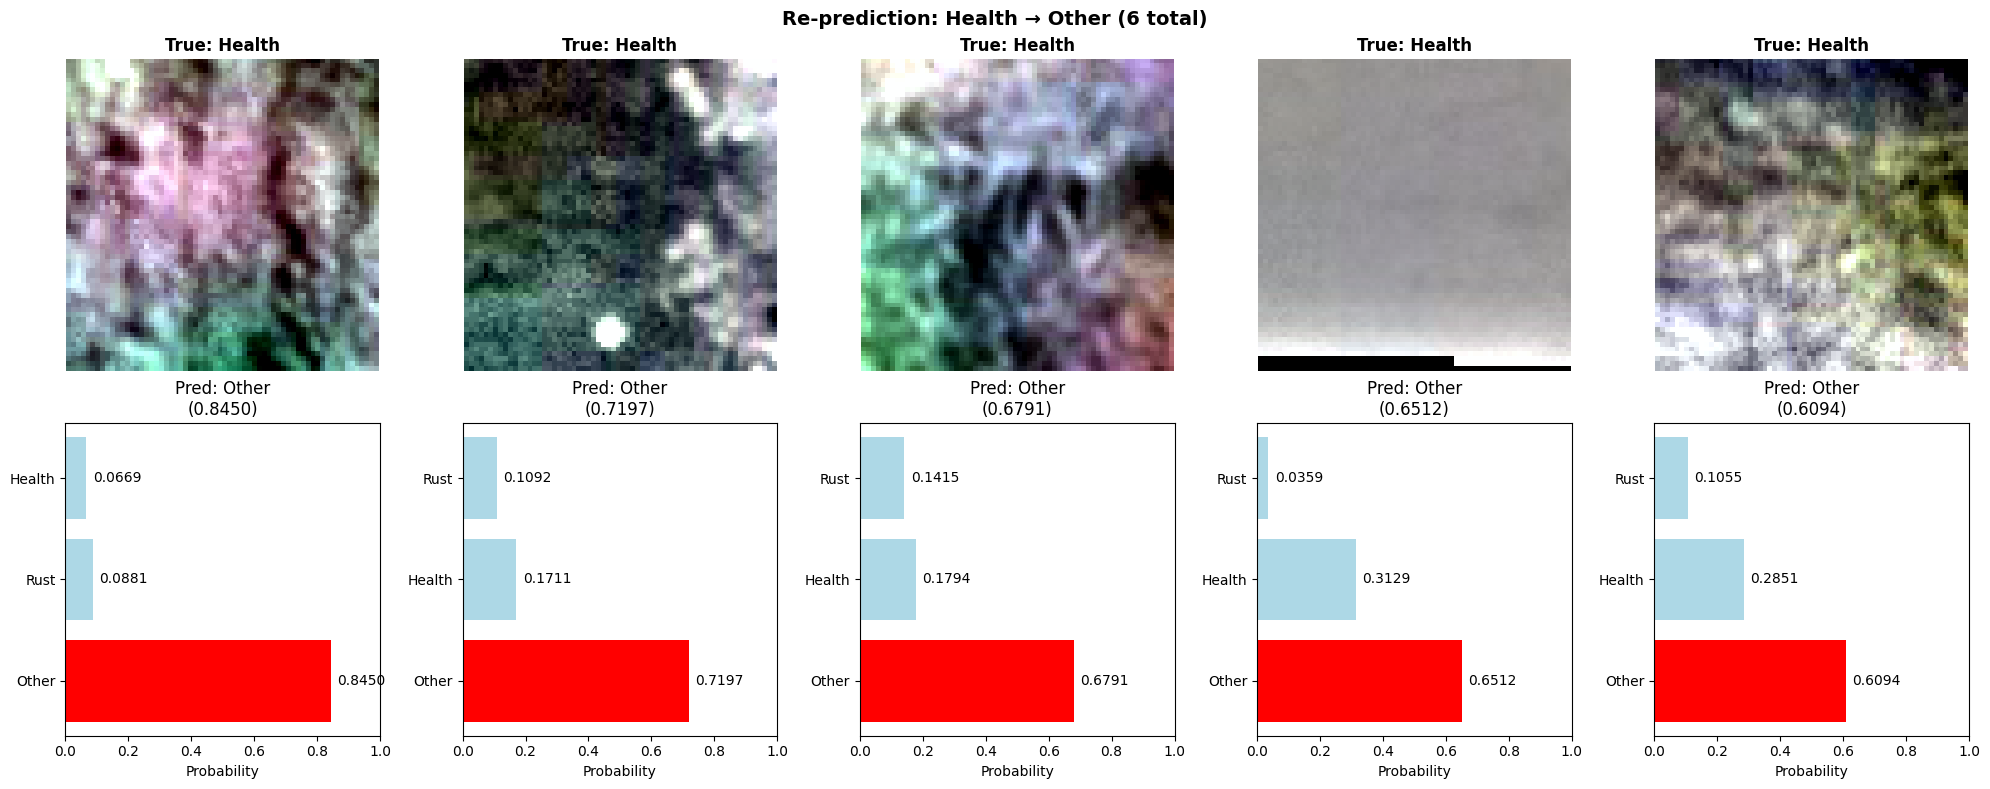

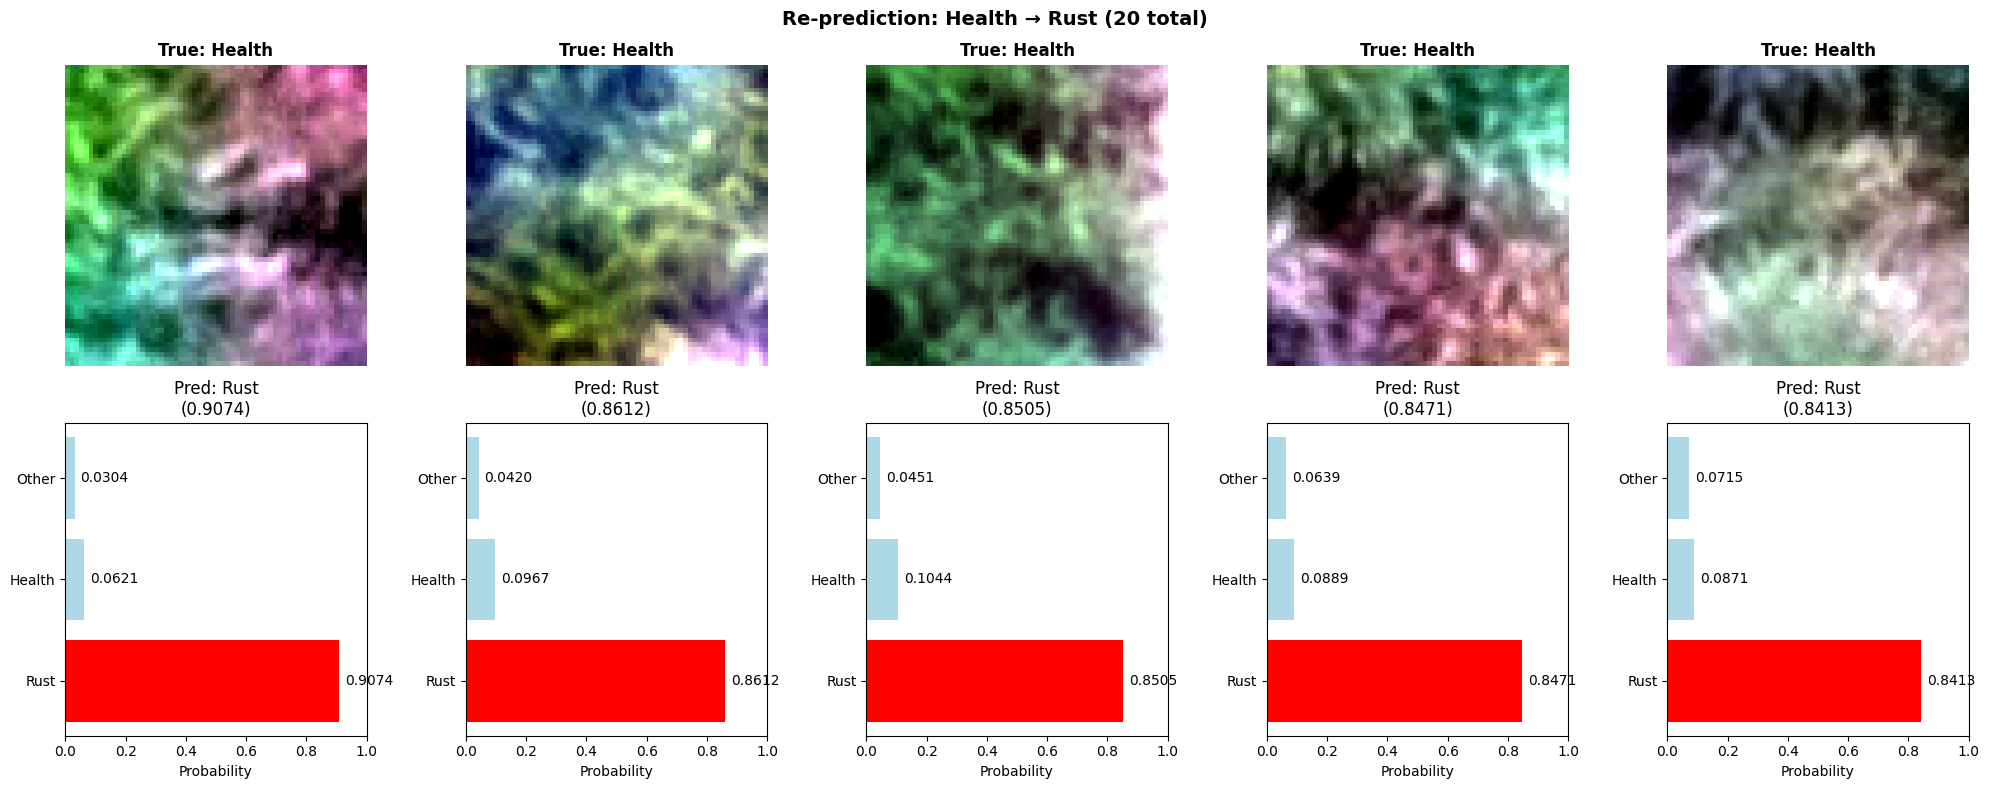

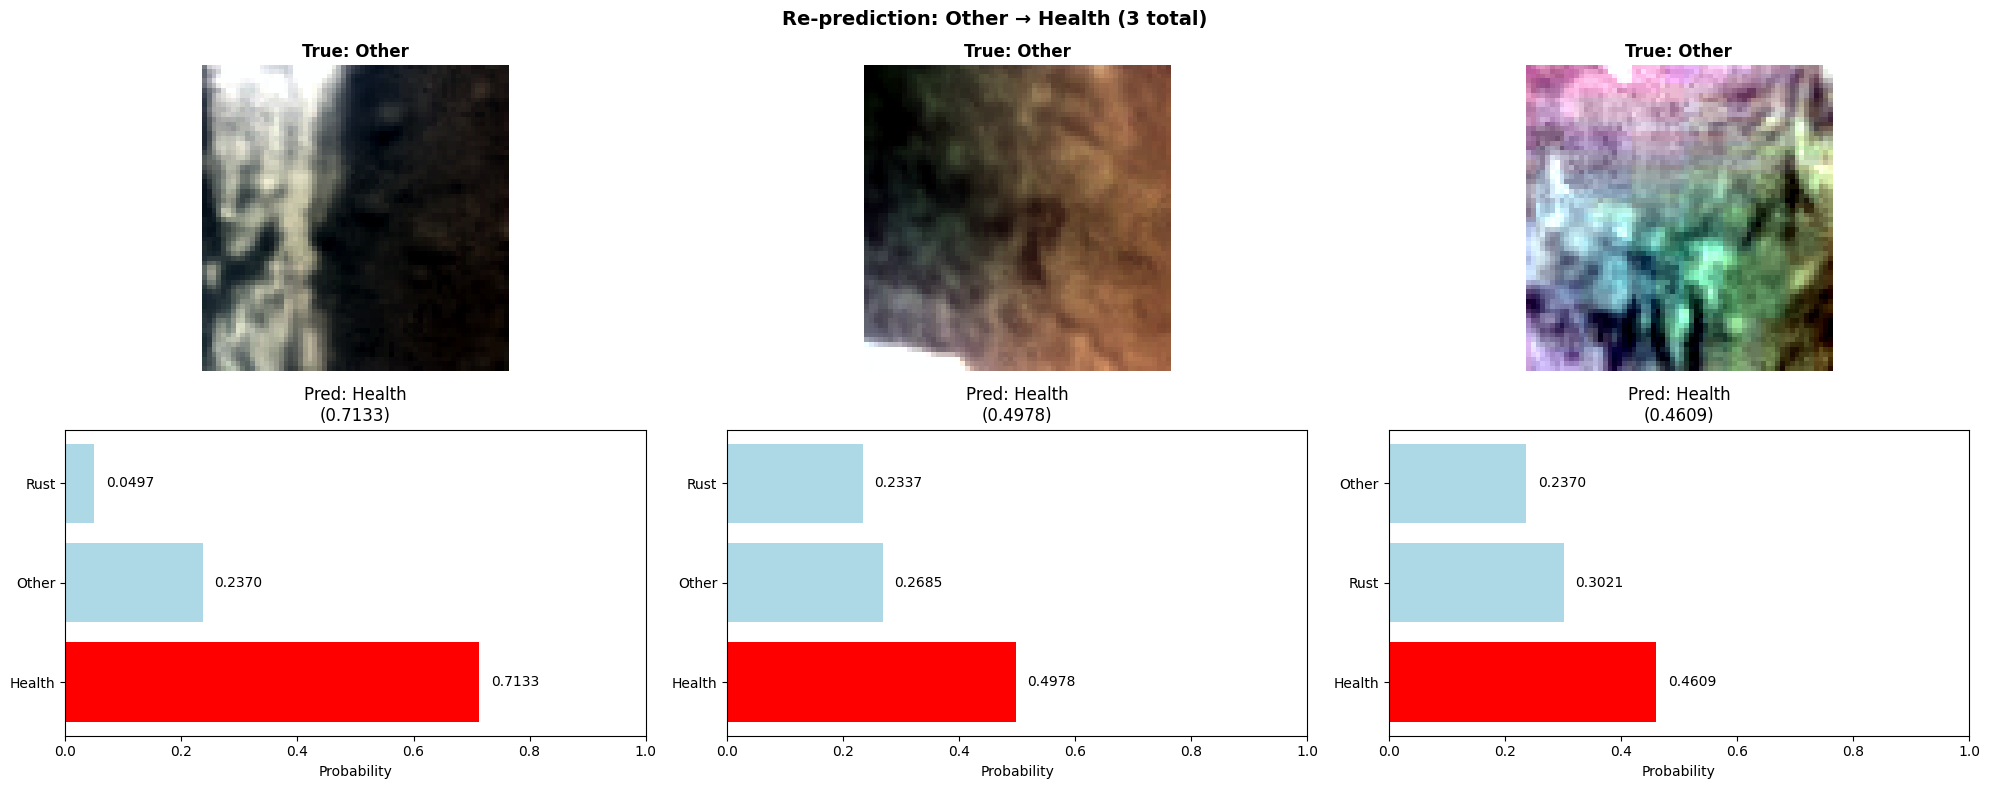

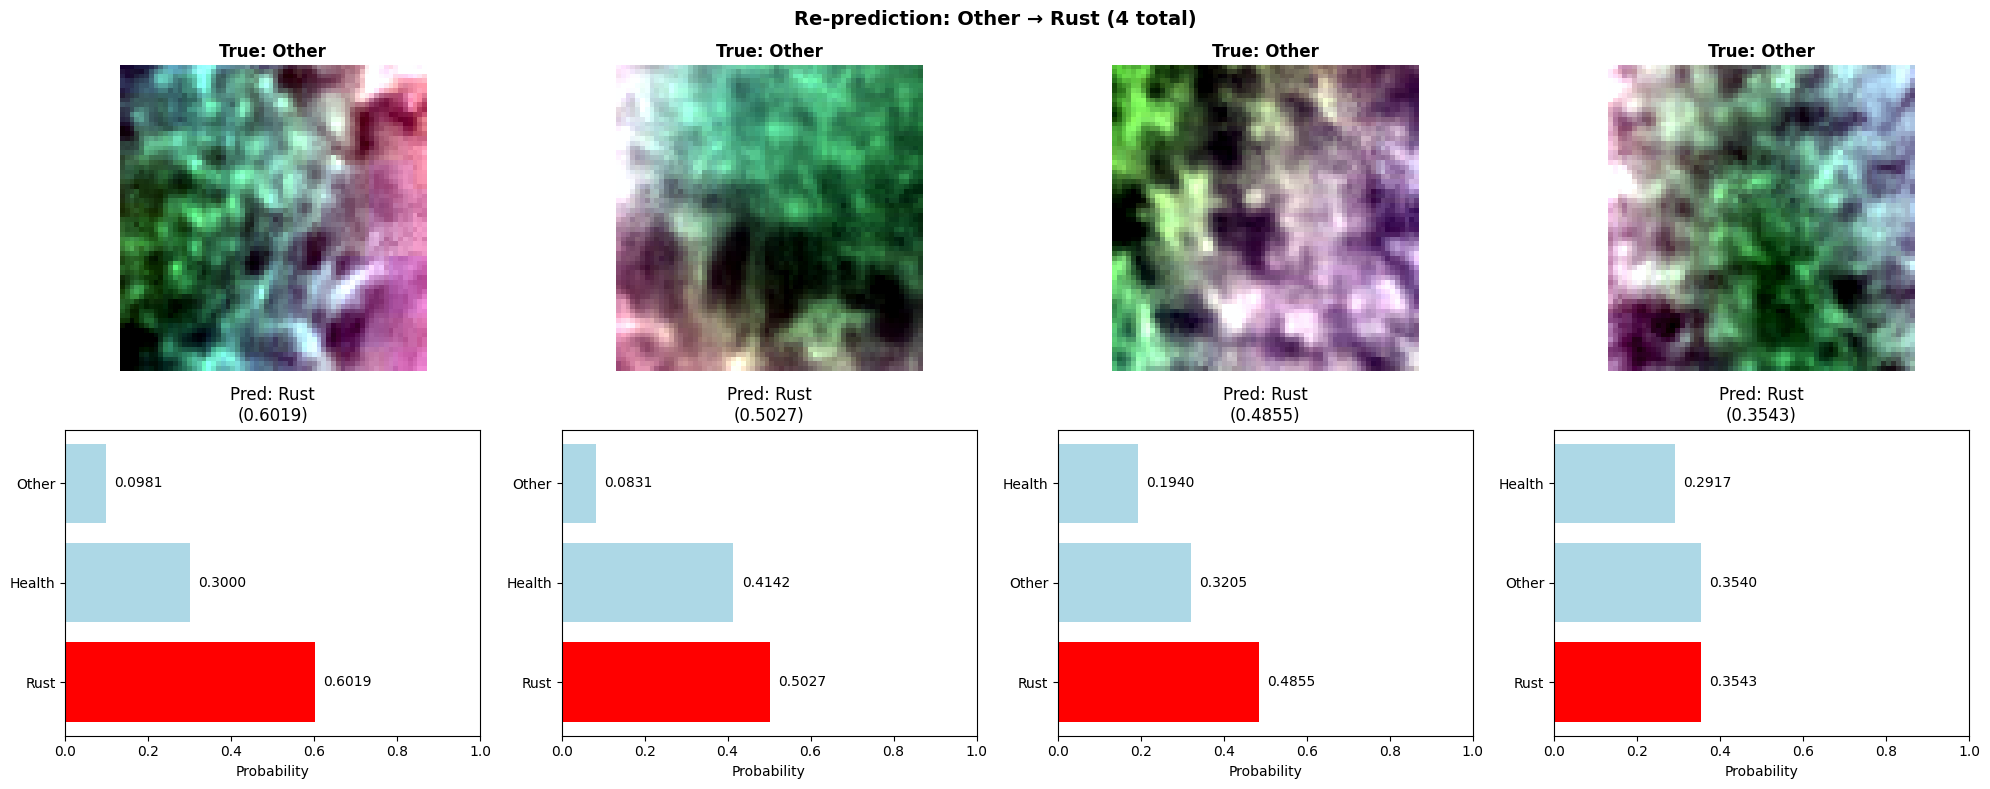

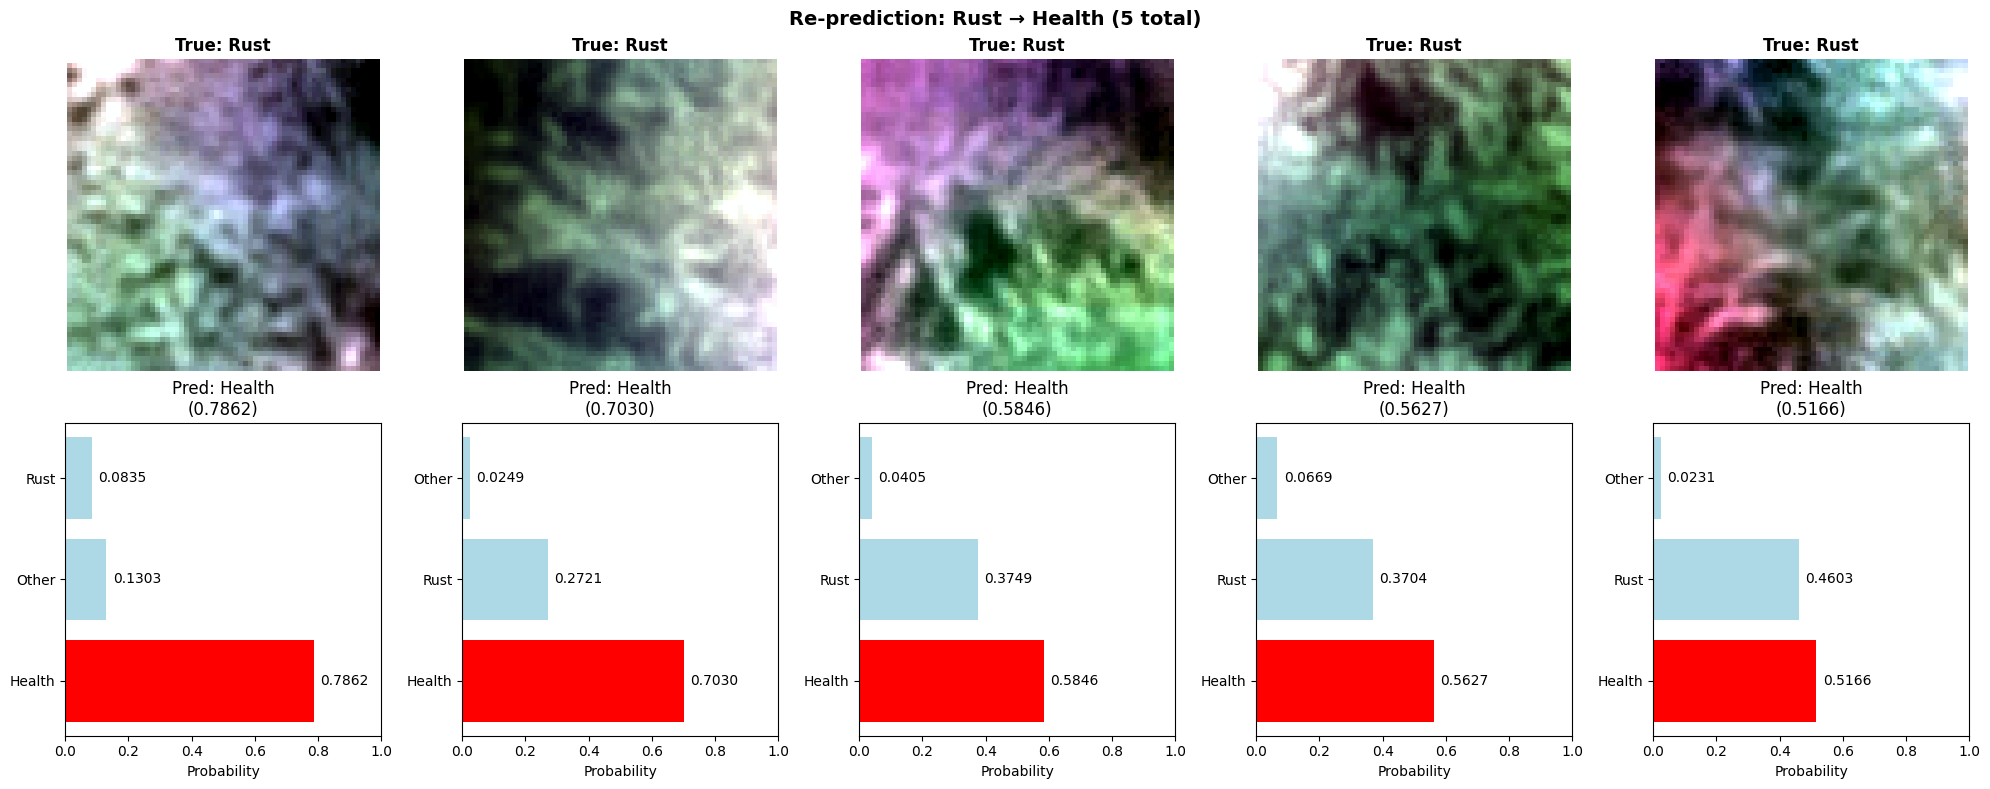

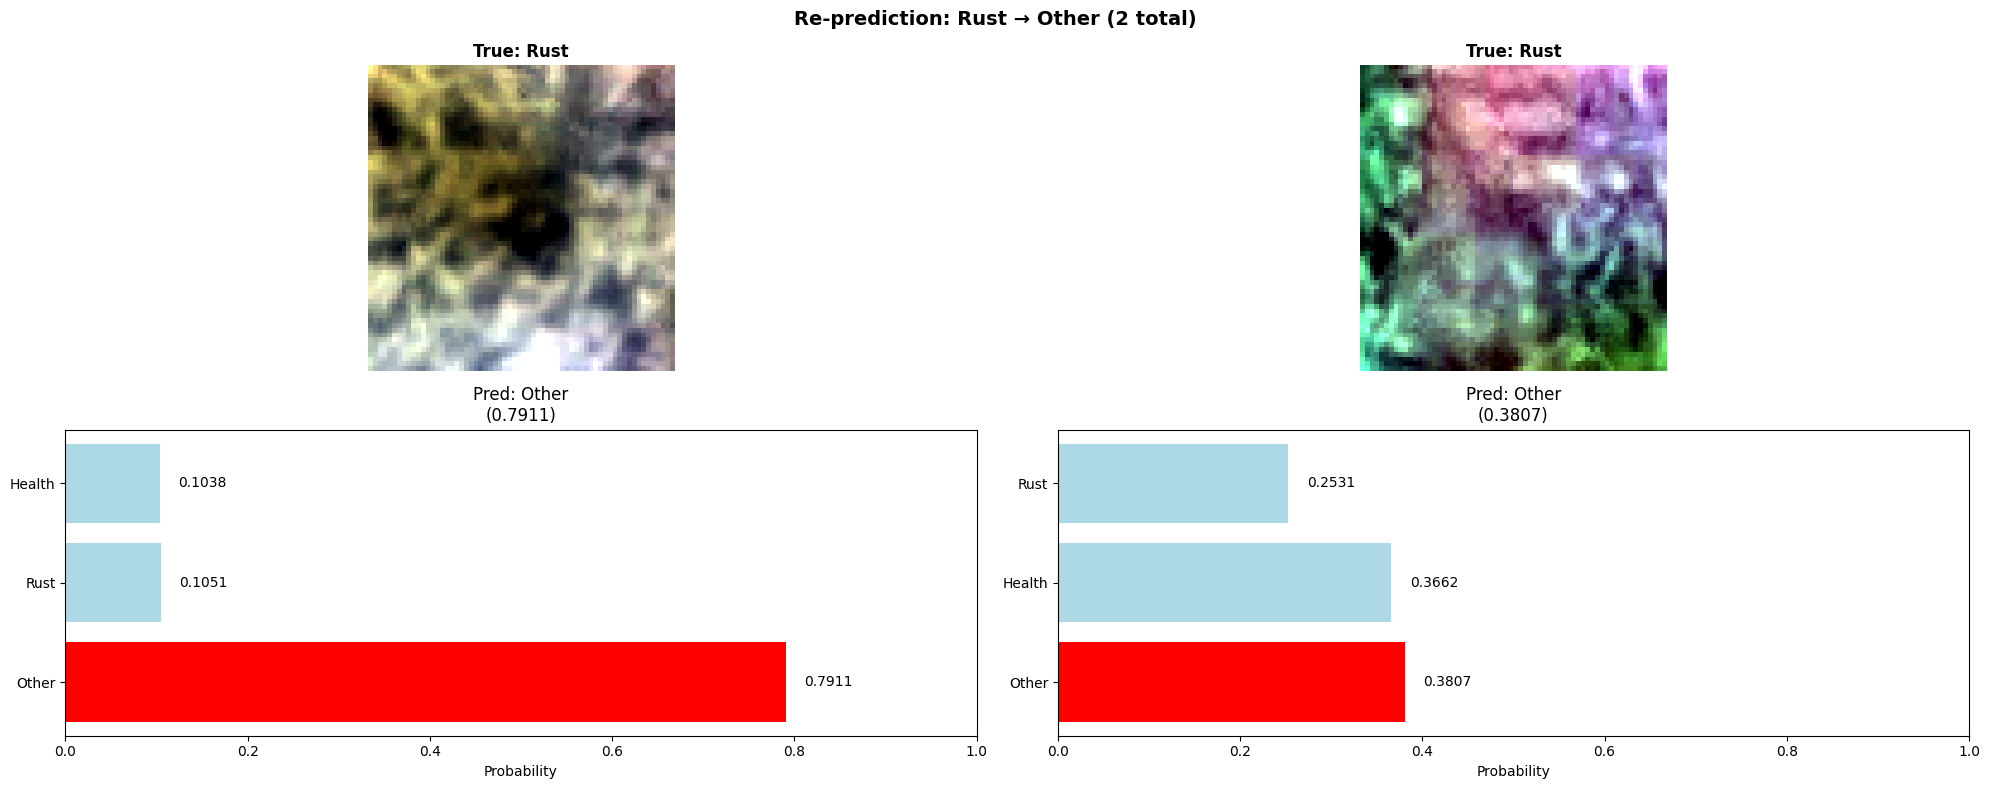

In [21]:
# Re-predict misclassified images
print("=== Re-predicting Misclassified Images ===\n")

# Collect all misclassified images with their predictions
misclassified_data = []

with torch.no_grad():
    val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    
    for idx, (images, labels) in enumerate(val_dl):
        images = images.to(device)
        outputs = model(images)
        
        # Get top-k predictions
        probabilities = torch.softmax(outputs, dim=1)
        top_k_probs, top_k_indices = torch.topk(probabilities, 3, dim=1)
        
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        true = labels.numpy()[0]
        
        if pred != true:
            true_label = val_ds.idx_to_class[true]
            pred_label = val_ds.idx_to_class[pred]
            confidence = probabilities[0, pred].item()
            
            misclassified_data.append({
                'idx': idx,
                'true_label': true_label,
                'pred_label': pred_label,
                'confidence': confidence,
                'top3_labels': [val_ds.idx_to_class[i.item()] for i in top_k_indices[0]],
                'top3_probs': [p.item() for p in top_k_probs[0]],
                'filename': val_ds.files[idx]
            })

# Sort by confidence (most confident wrong predictions first)
misclassified_data.sort(key=lambda x: x['confidence'], reverse=True)

print(f"Total misclassified images: {len(misclassified_data)}\n")

# Display detailed predictions
print("Top 10 Most Confident Misclassified Predictions:")
print("-" * 100)
for i, item in enumerate(misclassified_data[:10]):
    print(f"{i+1}. Image: {item['filename']}")
    print(f"   True Label: {item['true_label']}")
    print(f"   Predicted: {item['pred_label']} (Confidence: {item['confidence']:.4f})")
    print(f"   Top-3 Predictions:")
    for j, (lbl, prob) in enumerate(zip(item['top3_labels'], item['top3_probs'])):
        print(f"      {j+1}. {lbl}: {prob:.4f}")
    print()

# Visualize re-predictions
print("\n=== Visualizing Re-Predictions ===\n")

for (true_lbl, pred_lbl), _ in sorted(misclassified.items()):
    items = [item for item in misclassified_data if item['true_label'] == true_lbl and item['pred_label'] == pred_lbl]
    
    if not items:
        continue
    
    num_show = min(5, len(items))
    fig, axes = plt.subplots(2, num_show, 
                             figsize=(20, 8),
                             squeeze=False)
    
    fig.suptitle(f"Re-prediction: {true_lbl} → {pred_lbl} ({len(items)} total)", 
                 fontsize=14, fontweight='bold')
    
    for i in range(num_show):
        item = items[i]
        idx = item['idx']
        img_tensor, _ = val_ds[idx]
        img_display = denormalize_image(img_tensor)
        
        # Image
        axes[0, i].imshow(img_display)
        axes[0, i].set_title(f"True: {item['true_label']}", fontweight='bold')
        axes[0, i].axis('off')
        
        # Predictions bar chart
        top3_labels = item['top3_labels']
        top3_probs = item['top3_probs']
        colors = ['red' if lbl == item['pred_label'] else 'lightblue' for lbl in top3_labels]
        
        axes[1, i].barh(top3_labels, top3_probs, color=colors)
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_title(f"Pred: {item['pred_label']}\n({item['confidence']:.4f})")
        axes[1, i].set_xlabel("Probability")
        
        for j, (lbl, prob) in enumerate(zip(top3_labels, top3_probs)):
            axes[1, i].text(prob + 0.02, j, f'{prob:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()